In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from scipy.optimize import curve_fit
import sympy as sp

from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

import gstools as gs

In [3]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [4]:
A = np.array([[7, 2, 10], [5, 8, 7], [10, 5, np.nan]])
B = np.where(A <= 6, A, 0)
print(np.delete(A.reshape(-1),  np.where(A.reshape(-1) <= 6)).shape[0])
print(np.where(A.reshape(-1) > 6)[0].shape[0])

6
5


(10,) (10,)


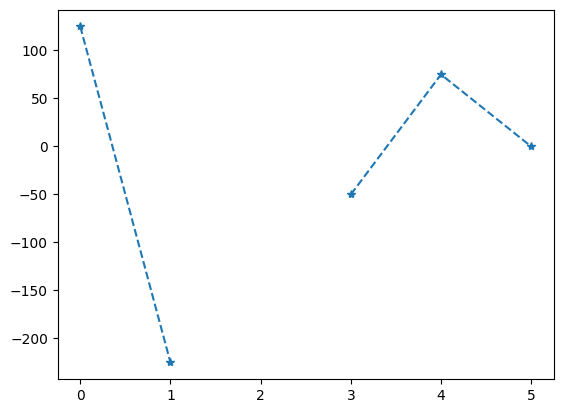

Проверка не нормированной корр. функции 125.0 125.0
(80,) (80,)


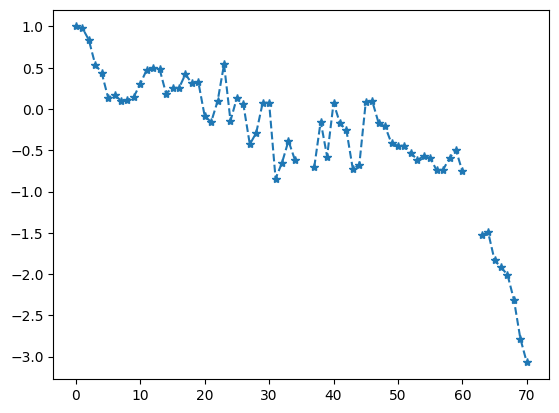

Проверка не нормированной корр. функции 14.438845872899925 1.0


In [5]:
"""
Создание матрицы расстояний и произведение значений
"""
def get_corr(points, values, max_h, start=0, step=1, normal=False):
    def matrix_distance_and_value(points, values):

        l = len(points)
        D = np.zeros((l, l))
        V = np.zeros((l, l))
        M = np.mean(values)
        var = np.var(values)

        for i in range(l):
            for j in range(i, l):
                distance = np.linalg.norm(points[i] - points[j])
                D[i, j] = distance

                if normal:
                    V[i, j] = (values[i]-M)*(values[j]-M) / var
                else:
                    V[i, j] = (values[i]-M)*(values[j]-M)
        return D, V
    
    
    corr_list, h_list = [], []
    D, V = matrix_distance_and_value(points, values)
    
    for h in range(start, max_h, step):
        """
        Суммарная корреляция в диапазоне (h-step, h-step]
        """
        sum_V = np.sum(np.where((D <= h) & (D > h-step), V, 0))

        """
        количество элементов в диапазоне (h-step, h-step]
        """
        D_list = D.reshape(-1)
        num_V = np.where((D_list <= h) & (D_list > h-step))[0].shape[0]

        if h == 0:
            """
            Частный случай корр. в точки 0
            """
            num_V = len(points)

        h_list.append(h)
        corr_list.append(sum_V/num_V)
    
    return np.array(h_list), np.array(corr_list)


# Пример построения корр функции
B = np.array([[1, 2, 3], [3, 4, 5], [1, 5, 7], [1, 2, 4]])
V = np.array([10, 20, 30, 40])
x, y = get_corr(B, V, 10)
print(x.shape, y.shape)
plt.plot(x, y, "--*")
plt.show()
print("Проверка не нормированной корр. функции", np.var(V), y[0])

#
borehole = "тсз147"
soil = "сугл."
df = pd.read_excel("data" + "\\" + borehole +".xlsx")
df = df.query("soil_kind == @soil")
df = df.loc[:, ["E", "soil_kind", "h"]]
df_filter = get_filter_df(df, "E")
# Вычисление скользящего среднего для определения тренда
window_size = 20  # Размер окна для скользящего среднего
df_filter['Trend'] = df_filter['E'].rolling(window=window_size, center=True).mean()
# Вычисление случайной составляющей как разность исходных данных и тренда
df_filter['Random'] = df_filter['E'] - df_filter['Trend']

x, y = get_corr(df_filter["h"].to_numpy()*10, df_filter['E'].to_numpy(), 80, normal=True)
print(x.shape, y.shape)
plt.plot(x, y, "--*")
plt.show()
print("Проверка не нормированной корр. функции", np.var(df_filter['E'].to_numpy()), y[0])

In [6]:
class MyCovModel(gs.CovModel):
    """
    Класс для использования своей ковариационной функции в кригинге из библиотеки gs
    """
    def __init__(self, dim=3, var=1.0, len_scale=1.0, nugget=0.0, anis=1.0, 
                 angles=0.0, 
                 **kwargs
                ):
        super().__init__(dim)
        self.var = var
        self.len_scale = len_scale
        self.nugget = nugget
        self.anis = anis
        self.angles = angles

        self.Dl = kwargs.get('Dl', .25)
        self.Df = kwargs.get('Df', .02)
        self.w = kwargs.get('w', 4)

    def cor(self, h):
        # Здесь определяем ковариационную функцию
        #return np.exp(-np.abs(h) / self.len_scale)
        return self.Dl * np.exp(-np.abs(h)/self.len_scale) + self.Df * np.exp(-np.abs(h)/self.len_scale) * np.cos(h/self.w)
        #return self.Dl * np.exp(-np.abs(h)/self.len_scale) + self.Df * np.exp(-np.abs(h)/self.len_scale) * np.cos(h/self.w) + self.nugget


def my_cor_func(h, dl, df, al, af, w):
    """
    Возвращает нашу ковар. функцию, необходимо для подбора параметров
    """
    #df=0.1
    #return abs(df)*np.exp(-abs(h)/af)*np.cos(h/w)
    return abs(dl)*np.exp(-abs(h)/af) + abs(df)*np.exp(-abs(h)/af)*np.cos(h/w)

## Исходные данные

In [7]:
df_house_3 = pd.read_excel("data/house_3_local.xlsx")
max_borehole = df_house_3["тсз"].max()

In [8]:
"""
Случайная разбивка данных  + добавление постоянных значений в тестовую выборку
    -только суглинок (залегает от 73,5 до 67-64,4)
    -пласт подряд идущих данных отнесен к тестовой выборке
    -отсортированные данные
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")

df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_now = get_filter_df(df, "E")

data_train, data_test = train_test_split(
    pd.concat([df_now.iloc[:91], df_now.iloc[128:]]).to_numpy(), 
    test_size=0.1, 
    random_state=123
)

data_train = data_train[np.argsort(data_train[:, 1])]
data_test = np.concatenate([data_test, df_now.iloc[92:128].to_numpy()])
data_test = data_test[np.argsort(data_test[:, 1])]
p_train, x_train, target_train = data_train[:, :2], data_train[:, :2], data_train[:, 2]
p_test, x_test, target_test = data_test[:, :2], data_test[:, :2], data_test[:, 2]

r2_dict = {}

## Построение корр. по скважине

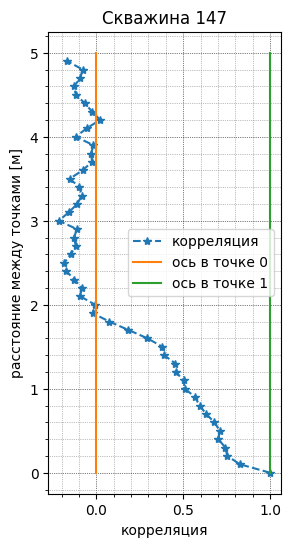

In [9]:
scale_x = 10
corr_size = 5 * scale_x

show_plot_flag = True
corr_normal = True
model = 'exponential'

x = x_train[:, 1] * scale_x
y = np.array([0]*x.shape[0])
E = target_train.copy()

    # построение корр функции
x_plot, y_plot = get_corr(x, E, corr_size, normal=corr_normal)

    
if show_plot_flag:
        plt.figure(figsize=(3, 6))
        plt.title(f'Скважина {borehole}')
        plt.xlabel('корреляция')
        plt.ylabel('расстояние между точками [м]')
        plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.minorticks_on()

        plt.plot(y_plot, x_plot/scale_x, "--*", label="корреляция")
        plt.plot([0, 0], [0, corr_size/scale_x], "-", label="ось в точке 0")

        if corr_normal:
            plt.plot([1, 1], [0, corr_size/scale_x], "-", label="ось в точке 1")
        
        plt.legend()
        plt.show()

[1.08840433e+00 1.38379367e-08 1.00000000e+00 9.13797999e+00
 7.39950760e-02]


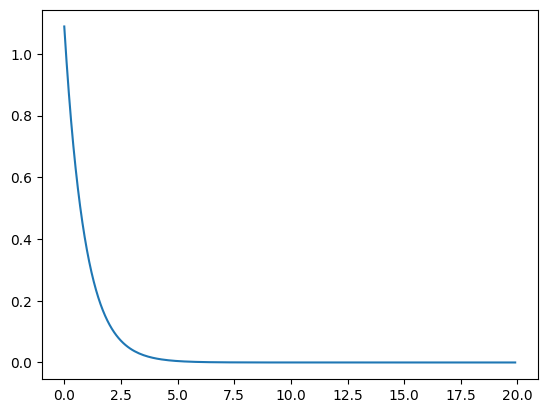

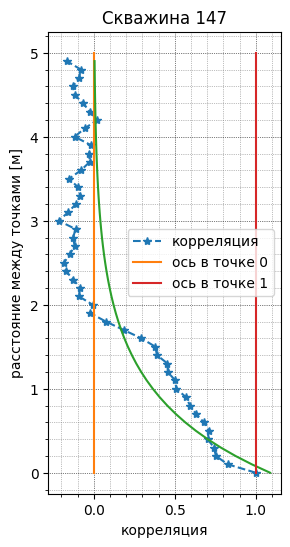

In [10]:
try:
    popt, pcov = curve_fit(my_cor_func, x_plot, y_plot)
except Exception as ex:
    print("Err in", ex, "\n", 10*"=")

Dl, Df, al, af, w  = popt
print(popt)

plt.plot(np.array(range(0, 200))/10, my_cor_func(np.array(range(0, 200)), *popt))

if show_plot_flag:
        plt.figure(figsize=(3, 6))
        plt.title(f'Скважина {borehole}')
        plt.xlabel('корреляция')
        plt.ylabel('расстояние между точками [м]')
        plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.minorticks_on()

        plt.plot(y_plot, x_plot/scale_x, "--*", label="корреляция")
        plt.plot([0, 0], [0, corr_size/scale_x], "-", label="ось в точке 0")
        
        plt.plot(my_cor_func(x_plot, *popt), x_plot/scale_x)

        if corr_normal:
            plt.plot([1, 1], [0, corr_size/scale_x], "-", label="ось в точке 1")
        
        plt.legend()
        plt.show()


-137.57656444629015


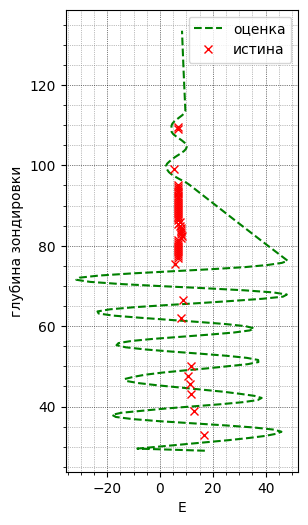

In [11]:
x = x_train[:, 0] * scale_x
y = x_train[:, 1] * scale_x

E = target_train.copy()

# Параметры модели
dim = 1  # Размерность пространства
var = 1.0  # Дисперсия
anis = 1.0  # Коэффициент анизотропии
angles = 0.0  # Угол поворота
nugget = 0

Dl, Df, _, len_scale, w  = popt

# Создание модели
model = MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, anis=anis, angles=angles,
                   Dl=Dl, Df=Df, al=al, af=af, w=w
                   )

OK = UniversalKriging(x, 
                      y, 
                      E, 
                      variogram_model=model
                     )
    
x_new = np.array([0]*200)
y_new = np.linspace(np.min(y), np.max(y)+2*scale_x, 200)
    
z_new, variance = OK.execute('points', x_new, y_new)

predict_test, variance = OK.execute('points', x_test[:, 0] * scale_x, x_test[:, 1] * scale_x)

print(r2_score(target_test, predict_test))
    
plt.figure(figsize=(3, 6))
#plt.plot(predict_test, x_test[:, 1], '*', label="оценка")
plt.plot(z_new, y_new, 'g--', label="оценка")
#plt.plot(target_train, x_train[:, 1] * scale_x, 'rx', label="истина")
plt.plot(target_test, x_test[:, 1] * scale_x, 'rx', label="истина")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()

## Крайгинг

In [12]:
scale_x = 1
corr_size = 8 * scale_x

In [13]:
x = x_train[:, 0] * scale_x
y = x_train[:, 1] * scale_x
E = target_train.copy()

"""
Подбор для MyCorr
"""
#pivot_r2 = pd.DataFrame(columns=[''])

top_r2 = 0
top_params = "mean"

dim = 1  # Размерность пространства
var = 1  # Дисперсия
nugget = 1
w = 1
anis = 1
angles = 0
Df=0.5
Dl=0.5

for len_scale in range(1, 8):  # Масштаб корреляции
    for nugget in [0, 1, 5, 10, 12]:
        for w in range(1, 5):
                    model= MyCovModel(dim=dim, var=var, len_scale=len_scale, 
                                      nugget=nugget, anis=anis, angles=angles, 
                                      w=w, 
                                      Df=Df, Dl=Dl
                                     )
                    
                    OK = UniversalKriging(x, 
                                          y, 
                                          E, 
                                          variogram_model=model
                                         )
                    try:
                        predict_test, var_test = OK.execute('points', x_test[:, 0]*scale_x, x_test[:, 1]*scale_x)
                        r2_now = r2_score(target_test, predict_test)
                        print(round(r2_now, 3), len_scale, nugget, anis, angles, w)
                        if top_r2 < r2_now:
                            top_r2 = r2_now
                            top_params = [len_scale, nugget, anis, angles, w]
                    except ValueError as er:
                        print(er)

top_params_1 = top_params.copy()
print(top_r2, top_params)

0.777 1 0 1 0 1
0.865 1 0 1 0 2
0.877 1 0 1 0 3
0.881 1 0 1 0 4
0.726 1 1 1 0 1
0.83 1 1 1 0 2
0.844 1 1 1 0 3
0.849 1 1 1 0 4
0.558 1 5 1 0 1
0.686 1 5 1 0 2
0.704 1 5 1 0 3
0.71 1 5 1 0 4
0.387 1 10 1 0 1
0.525 1 10 1 0 2
0.546 1 10 1 0 3
0.552 1 10 1 0 4
0.332 1 12 1 0 1
0.47 1 12 1 0 2
0.491 1 12 1 0 3
0.498 1 12 1 0 4
0.948 2 0 1 0 1
0.949 2 0 1 0 2
0.949 2 0 1 0 3
0.949 2 0 1 0 4
0.897 2 1 1 0 1
0.905 2 1 1 0 2
0.908 2 1 1 0 3
0.909 2 1 1 0 4
0.871 2 5 1 0 1
0.863 2 5 1 0 2
0.856 2 5 1 0 3
0.853 2 5 1 0 4
0.813 2 10 1 0 1
0.777 2 10 1 0 2
0.758 2 10 1 0 3
0.75 2 10 1 0 4
0.785 2 12 1 0 1
0.739 2 12 1 0 2
0.717 2 12 1 0 3
0.707 2 12 1 0 4
0.944 3 0 1 0 1
0.947 3 0 1 0 2
0.948 3 0 1 0 3
0.948 3 0 1 0 4
0.866 3 1 1 0 1
0.893 3 1 1 0 2
0.896 3 1 1 0 3
0.897 3 1 1 0 4
0.859 3 5 1 0 1
0.824 3 5 1 0 2
0.807 3 5 1 0 3
0.799 3 5 1 0 4
0.792 3 10 1 0 1
0.691 3 10 1 0 2
0.655 3 10 1 0 3
0.64 3 10 1 0 4
0.759 3 12 1 0 1
0.639 3 12 1 0 2
0.598 3 12 1 0 3
0.581 3 12 1 0 4
0.943 4 0 1 0 1
0.947

In [14]:
"""
Подбор для MyCorr 2 этап
"""
top_r2 = 0
top_params = "mean"

dim = 1  # Размерность пространства
var = 1  # Дисперсия
len_scale, nugget, anis, angles, w = top_params_1

for w in range(1, 5):
    for Dl in [i/10 for i in range(5, 11)]:  # Коэффициент анизотропии
        for Df in [i/10 for i in range(1, 11)]:  # Угол поворота
                    model= MyCovModel(dim=dim, var=var, len_scale=len_scale, 
                                      nugget=nugget, anis=anis, angles=angles, 
                                      w=w, 
                                      Df=Df, Dl=Dl
                                     )
                    
                    OK = UniversalKriging(x, 
                                          y, 
                                          E, 
                                          variogram_model=model
                                         )
                    try:
                        predict_test, var_test = OK.execute('points', x_test[:, 0]*scale_x, x_test[:, 1]*scale_x)
                        r2_now = r2_score(target_test, predict_test)
                        print(round(r2_now, 3), w, Dl, Df)
                        if top_r2 < r2_now:
                            top_r2 = r2_now
                            top_params = [w, Dl, Df]
                    except ValueError as er:
                        print(er)

top_params_2 = top_params.copy()
print(top_r2, top_params)

0.908 1 0.5 0.1
0.905 1 0.5 0.2
0.903 1 0.5 0.3
0.904 1 0.5 0.4
0.948 1 0.5 0.5
-162.334 1 0.5 0.6
-388.75 1 0.5 0.7
0.593 1 0.5 0.8
0.662 1 0.5 0.9
-3.97 1 0.5 1.0
0.909 1 0.6 0.1
0.906 1 0.6 0.2
0.906 1 0.6 0.3
0.949 1 0.6 0.4
-126.337 1 0.6 0.5
-551.648 1 0.6 0.6
0.601 1 0.6 0.7
0.655 1 0.6 0.8
-3.731 1 0.6 0.9
-384.836 1 0.6 1.0
0.909 1 0.7 0.1
0.907 1 0.7 0.2
0.949 1 0.7 0.3
-100.572 1 0.7 0.4
-852.457 1 0.7 0.5
0.609 1 0.7 0.6
0.648 1 0.7 0.7
-3.636 1 0.7 0.8
-257.185 1 0.7 0.9
-9808.697 1 0.7 1.0
0.909 1 0.8 0.1
0.949 1 0.8 0.2
-81.592 1 0.8 0.3
-1511.722 1 0.8 0.4
0.617 1 0.8 0.5
0.64 1 0.8 0.6
-3.645 1 0.8 0.7
-183.735 1 0.8 0.8
-2189.308 1 0.8 0.9
-0.806 1 0.8 1.0
0.949 1 0.9 0.1
-67.288 1 0.9 0.2
-3476.488 1 0.9 0.3
0.624 1 0.9 0.4
0.631 1 0.9 0.5
-3.737 1 0.9 0.6
-137.685 1 0.9 0.7
-312.993 1 0.9 0.8
-0.758 1 0.9 0.9
-0.478 1 0.9 1.0
-56.31 1 1.0 0.1
-15853.358 1 1.0 0.2
0.632 1 1.0 0.3
0.622 1 1.0 0.4
-3.903 1 1.0 0.5
-106.963 1 1.0 0.6
-110.238 1 1.0 0.7
-0.711 1 1.0 0.8


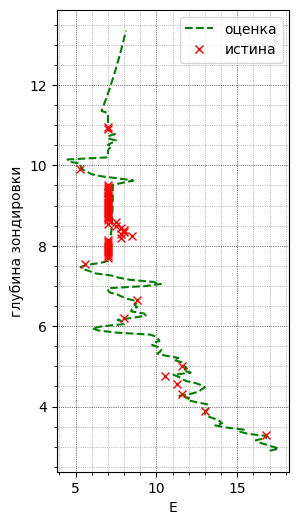

In [15]:
x = x_train[:, 0] * scale_x
y = x_train[:, 1] * scale_x


E = target_train.copy()

# Параметры модели
dim = 1  # Размерность пространства
var = 1.0  # Дисперсия
anis = 1.0  # Коэффициент анизотропии
angles = 0.0  # Угол поворота
len_scale, nugget, anis, angles, w = top_params_1
w, Dl, Df = top_params_2


# Создание модели
model = MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, anis=anis, angles=angles,
                   Dl=Dl, Df=Df, al=al, af=af, w=w
                   )

OK = UniversalKriging(x, 
                      y, 
                      E, 
                      variogram_model=model
                     )
    
x_new = np.array([0]*200)
y_new = np.linspace(np.min(y), np.max(y)+2*scale_x, 200)
    
z_new, variance = OK.execute('points', x_new, y_new)
    
    
plt.figure(figsize=(3, 6))
#plt.plot(predict_test, x_test[:, 1], '*', label="оценка")
plt.plot(z_new, y_new, 'g--', label="оценка")
#plt.plot(target_train, x_train[:, 1] * scale_x, 'rx', label="истина")
plt.plot(target_test, x_test[:, 1] * scale_x, 'rx', label="истина")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()

## Построение по всем известным данным

Тест

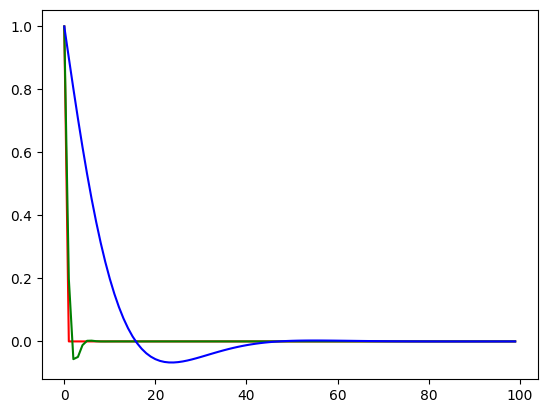

In [16]:
def func1(h, df, af, w, c):
    return abs(df)*np.exp(-abs(h)/af) *np.cos(h/w) + c


X = np.array(range(100))

plt.plot(X, func1(X, 1, .1, .1, 0), "-r")
plt.plot(X, func1(X, 1, 1, 1, 0), "-g")
plt.plot(X, func1(X, 1, 10, 10, 0), "-b")

0.9487582523303031


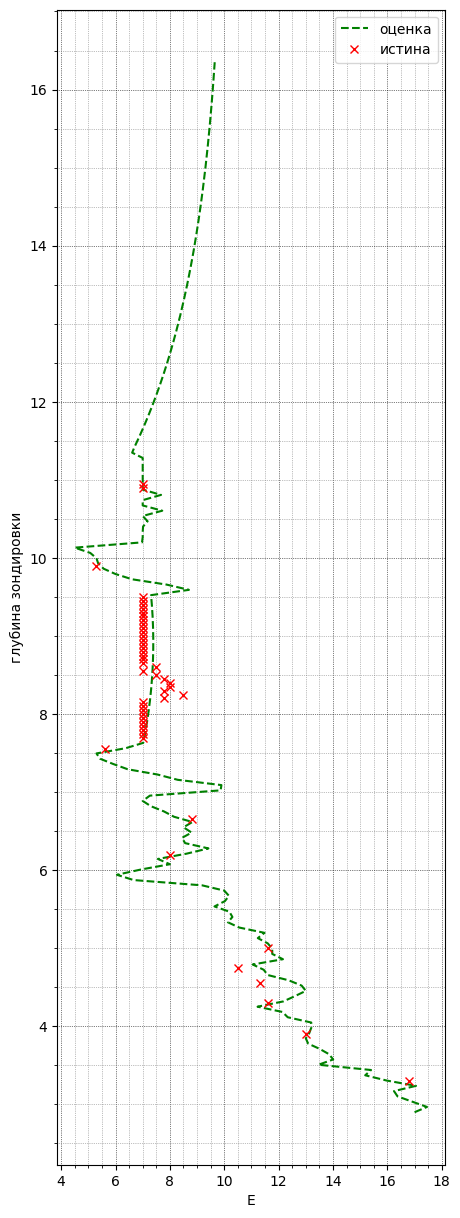

In [17]:
"""
Универсальный кригинг
"""
model = 'exponential'

x = x_train[:, 0]
y = x_train[:, 1]
E = target_train

OK = UniversalKriging(x, 
                      y, 
                      E, 
                      variogram_model=model
                        )

predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
print(r2_score(target_test, predict_test))
r2_dict["UK"] = r2_score(target_test, predict_test)

x_new = np.array([0]*200)
y_new = np.linspace(np.min(y), np.max(y)+5, 200)
z_new, variance = OK.execute('points', x_new, y_new)

plt.figure(figsize=(5, 15))
#plt.plot(predict_test, x_test[:, 1], '*', label="оценка")
plt.plot(z_new, y_new, 'g--', label="оценка")
plt.plot(target_test, x_test[:, 1], 'rx', label="истина")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()